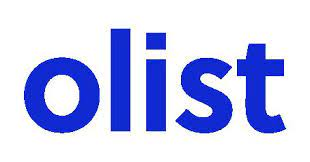

# <a name = "sommaire"> Sommaire 

- <a href ="#import"> Importation des bibliothèques et des données </a>
- <a href ="#fonc"> Fonction visualisation </a>
- <a href ="#pre1"> 1ere transformation</a>
- <a href ="#pre2"> 2eme transformation</a>
- <a href ="#pred1"> Modélisation</a>
    - <a href ="#pred2"> Kmeans </a>
    - <a href ="#pred3"> Clustering ascendant hiérarchique </a>
    - <a href ="#pred4"> DBSCAN </a>
- <a href ="#pred5"> Première selection </a>
- <a href ="#pred7"> Segmentation classique (RFM) </a>
- <a href ="#conc"> Conclusion </a>

# <a name = "import"> Importation des bibliothèques et des données</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from scipy import stats
import plotly.express as px
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

from sklearn import set_config
set_config(display='diagram')
import os
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/P5 segmentation/data/olist_final.csv')

#<a name = "import"> Fonction visualisation</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
def score_elbow(df, clf):
  #fig, axs = plt.subplots(1, 2, figsize = (20, 12))
  visualizer = KElbowVisualizer(clf, k=(1,10))
  visualizer.fit(df) 
  visualizer.show()
  # for k, i in enumerate(['distortion', 'silhouette']):
  #   if i == 'distortion':
  #     visualizer = KElbowVisualizer(clf, k=(1,10), metric = i, ax = axs[k])
  #     visualizer.fit(df) 
  #     visualizer.finalize()
    # else: 
    #   visualizer = KElbowVisualizer(clf, k=(2,7), metric = i, ax = axs[k])
    #   visualizer.fit(df) 
    #   visualizer.finalize()

#------------------------------------------------------------------------------

def display_pca_circle(pca_comp, axis, pca, ax = None, reduce = None):
  # paramétre figure
  ax = ax
  plt.rcParams.update({'font.size': 14})

  # tracer cercle
  circle1 = plt.Circle((0, 0), 1,color = 'maroon', fill = False)
  plt.gca().add_patch(circle1)
  plt.xlim(-1, 1)
  plt.ylim(-1, 1)
  x=np.linspace(start=-1,stop=1,num=30)
  ax.scatter(x,[0]*len(x), marker='_',color='maroon')
  ax.scatter([0]*len(x), x, marker='|',color='maroon')

  # Affichage des fleche
  if reduce:
    for i in range(len(pca_comp[0])):
      xi=pca_comp[axis[0]][i]
      yi=pca_comp[axis[1]][i]
      if abs(round(xi, 2)) > 0.05 or  abs(round(yi, 2)) > 0.05:
        ax.arrow(0,0, 
                    dx=xi, dy=yi, 
                    head_width=0.03, head_length=0.03, 
                    color= 'black', length_includes_head=True)  
        add_string=f" ({round(xi,2)} {round(yi,2)})"
        ax.text(pca_comp[axis[0], i], 
                  pca_comp[axis[1], i] , 
                  s=X.columns[i] + add_string ) 
    ax.set_xlabel(f'F{axis[0] + 1} ({round(100*pca.explained_variance_ratio_[axis[0]],1)})%')
    ax.set_ylabel(f'F{axis[1] + 1} ({round(100*pca.explained_variance_ratio_[axis[1]],1)})%')
    ax.set_title(f'Cercle des corrélations F{axis[0] + 1} et F{axis[1] + 1}')
  else: 
    for i in range(len(pca_comp[0])):
      xi=pca_comp[axis[0]][i]
      yi=pca_comp[axis[1]][i]
      ax.arrow(0,0, 
                    dx=xi, dy=yi, 
                    head_width=0.03, head_length=0.03, 
                    color= 'black', length_includes_head=True)  
      add_string=f" ({round(xi,2)} {round(yi,2)})"
      ax.text(pca_comp[axis[0], i], 
                  pca_comp[axis[1], i] , 
                  s=X.columns[i] + add_string ) 
    ax.set_xlabel(f'F{axis[0] + 1} ({round(100*pca.explained_variance_ratio_[axis[0]],1)})%')
    ax.set_ylabel(f'F{axis[1] + 1} ({round(100*pca.explained_variance_ratio_[axis[1]],1)})%')
    ax.set_title(f'Cercle des corrélations F{axis[0] + 1} et F{axis[1] + 1}')



def display_factorial_planes(pca_trans, axis, pca, illu_var = None, ax = None, order = None, palette = None):
  ax = ax
  x, y = pca_trans[:,axis[0]], pca_trans[:,axis[1]]
  sns.scatterplot(x=x, y=y, hue = illu_var, ax = ax, hue_order = order, palette = palette, alpha = 0.5)

  ax.axhline(y=0, color="maroon", linestyle="--")
  ax.axvline(x=0, color="maroon", linestyle="--")

  ax.set_xlabel(f'F{axis[0] + 1} ({round(100*pca.explained_variance_ratio_[axis[0]],1)})%')
  ax.set_ylabel(f'F{axis[1] + 1} ({round(100*pca.explained_variance_ratio_[axis[1]],1)})%')
  ax.set_title(f'Projection des individus F{axis[0] + 1} et F{axis[1] + 1}')

# --------------------------------------------------------------------------------

def visualizer(df, clf):
  fig, axs = plt.subplots(1, 2, figsize = (20, 12))
  visualizer = InterclusterDistance(clf, embedding = 'tsne', ax = axs[0])
  visualizer.fit(df)
  visualizer.finalize() 

  visualizer = SilhouetteVisualizer(clf, colors='yellowbrick', ax = axs[1])
  visualizer.fit(df)
  visualizer.finalize() 

#<a name = "pre1"> 1ere transformation</a> <a href ="#sommaire"> Retour au sommaire</a>

Lors de l'analyse univariée on a pu voir des distributions très asymétriques, donc on va commencer ici par appliquer un log au distribution très asymétrique en utilisant la librairie stats pour vérifier l'asymétrie et numpy pour la transformation log. Ici lorsque le coef est < -0.5 ou > 0.5 signifie une disbritution très asymétrique ([SOURCE](https://docs.oracle.com/cd/E57185_01/CBREG/ch03s02s03s01.html#:~:text=A%20skewness%20value%20greater%20than,the%20distribution%20is%20fairly%20symmetrical)) et donc on effectuera la transformation.


In [ ]:
#coefficient d'asymétrie 
# for col in df.columns:
#    skew = stats.skew(df[col])
#    if skew < -0.5 or skew > 0.5:
#      df[col] = np.log1p(df[col])

Au vu des résultats très mauvais obtenus, cette partie ne sera pas excécutée pour la suite.

#<a name = "pre2"> 2eme transformation</a> <a href ="#sommaire"> Retour au sommaire</a>

Pour cette partie on va mettre à l'echelle nos données en essayant différentes méthodes et garder la méthode avec laquelle on aura des résultats satisfaisant :
- RobustScaler qui va permettre que les valeurs aberrantes aient moins d'impact
- MinMaxScaler qui va permettre d'avoir nos données dans une plage entre 0 et 1
- StandarScaler qui va permettre d'avoir une distribution avec une moyenne de 0 et un std de 1

In [ ]:
df.drop('customer_unique_id', axis = 1, inplace = True)
X = df.copy()
#sc = RobustScaler()
sc = MinMaxScaler()
#sc = StandardScaler()
df_sc = sc.fit_transform(X)
df_sc = pd.DataFrame(df_sc, columns = sc.feature_names_in_)

Au vu des résultats obtenus on gardera la mise à l'èchelle avec MinMaxScaler pour la première partie de modélisation.

#<a name = "pred1"> Modélisation </a> <a href ="#sommaire"> Retour au sommaire</a>

###<a name = "pred2"> Kmeans </a> <a href ="#sommaire"> Retour au sommaire</a>

**Explication:**

Le kmeans est l'un des algorithmes de clustering les plus populaires et son principe va être en plusieurs étapes :
- Etape 1: Selection au hasard de n points distinct qui vont être les clusters (définit avec le paramètre k)
- Etape 2 : Attibution de chaque point à son cluster le plus proche
- Etape 3 : Calculer la moyenne de chaque cluster, puis répeter les étapes 2, 3 jusqu'à ce que la moyenne ne bouge plus.

L'algorithme va ensuite calculer la somme totale des variances au sein des clusters et rèpeter les étapes 1,2,3 n fois (définit avec le paramètre n_init) et gardé le modèle qui minimise la somme totale des variances entre les clusters.

**Méthode du coude :**

Pour le choix optimal du paramètre k on va utiliser la méthode du coude en utilisant KElbowVisualizer de Yellowbrick qui implèmente cette méthode.

**Silhouette score**:

Pour la suite on va utiliser la métrique silhouette score qui va mesurer la qualité de nos clusters créer en retournant un score qui va être compris entre -1 et 1 qui va correspondre à la moyenne de la silhouette score de chaque point. Plus les points dans les clusters sont proches entre eux et plus la distance inter clusters est grande plus le score va s'approcher de 1 et donc:
- Un score de 1 va signifier que les clusters sont bien séparés les uns des autres et se distinguent.
- Un score de 0 va signifier que les clusters moyens sont indifférents.
- Un score de -1 va signifier que les clusters moyens sont attribués de manières erronnées.

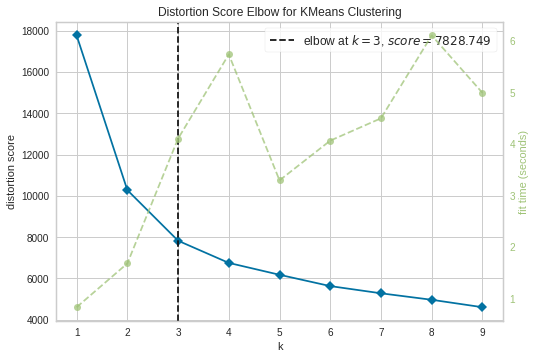

In [ ]:
clf = KMeans(random_state=0)
score_elbow(df_sc, clf)

In [ ]:
clf = KMeans(3, random_state=0)
clf.fit(df_sc)
print(f"Silhouette score : {silhouette_score(df_sc, clf.labels_)}")

Silhouette score : 0.3052944043600075


###<a name = "pred3"> Clustering ascendant hiérarchique </a> <a href ="#sommaire"> Retour au sommaire</a>

**Explication**: 

Le clustering ascendant hiérarchique va commencer par supposer que chaque point (ici client) est un cluster, ensuite chaque cluster est regroupé a son cluster le plus proche jusqu'à avoir un seul et unique cluster.

Comme le CAH est gourmand en temps de calcul, il est préferable de l'utiliser sur des petits jeux de données. Mais ici on va prendre un échantillon de notre dataset afin de le tester et le comparer aux autres algorithmes.

On va utiliser la même méthode que pour le Kmeans pour trouver le n_clusters optimal.

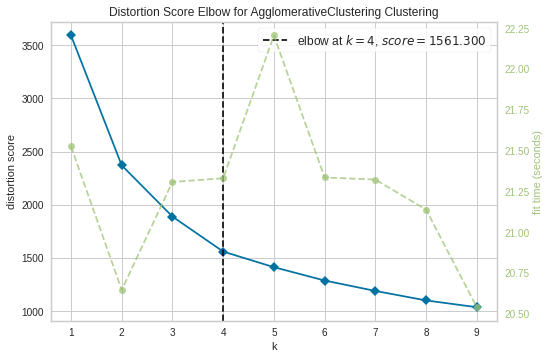

In [ ]:
df_sample = df_sc.sample(frac = 0.2, random_state = 0)
clf1 = AgglomerativeClustering()
score_elbow(df_sample, clf1)

In [ ]:
clf1 = AgglomerativeClustering(4)
clf1.fit(df_sample)
print(f"Silhouette score : {silhouette_score(df_sample, clf1.labels_)}")

Silhouette score : 0.2179451272183145


###<a name = "pred4"> DBSCAN </a> <a href ="#sommaire"> Retour au sommaire</a>

**Explication**:

Le DBSCAN va être basé sur la densité et donc capable de gérer les clusters imbriqués, on peut le diviser en plusieurs étape également:
- Etape 1 : l'algorithme va commencer par compter le nombre de point proche de chaque point en fonction du paramètre eps choisi
- Etape 2 : l'algorithme va définir les core points en fonction du paramètre min_samples.
- Etape 3 : tout core point qui sont à une distance eps d'un core point appartient à un même cluster.

Pour le DBSCAN on a deux paramètres à chercher:
- Eps: Qui va être la distance euclidienne autour d'un point afin de mesurer la proximité des autres points.
- min_sample: Si au moins n points sont à une distance eps alors le point sera considérer comme core point.


Choix parametre **min_samples**:

Si la dimension du dataset est > 2 alors il est recommandé de prendre min_samples = dim * 2 (Sources: [ici](https://www.sefidian.com/2020/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/) et [ici](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd))


In [ ]:
min_samples = df_sc.shape[1] * 2 

Choix parametre **eps**: 

On va dans un premier temps utiliser l'algorithme NearestNeighbors avec comme paramètre n_neighbors=min_samples qui va calculer la distance de tous les points de données.

Ensuite on pourra trier les valeurs de distance par ordre croissant et visualiser et choisir l'eps optimal en utilisant la méthode du coude. (Sources: [ici](https://www.sefidian.com/2020/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/) et [ici](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd))

In [ ]:
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(df_sc)
distances, indices = neighbors_fit.kneighbors(df_sc)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

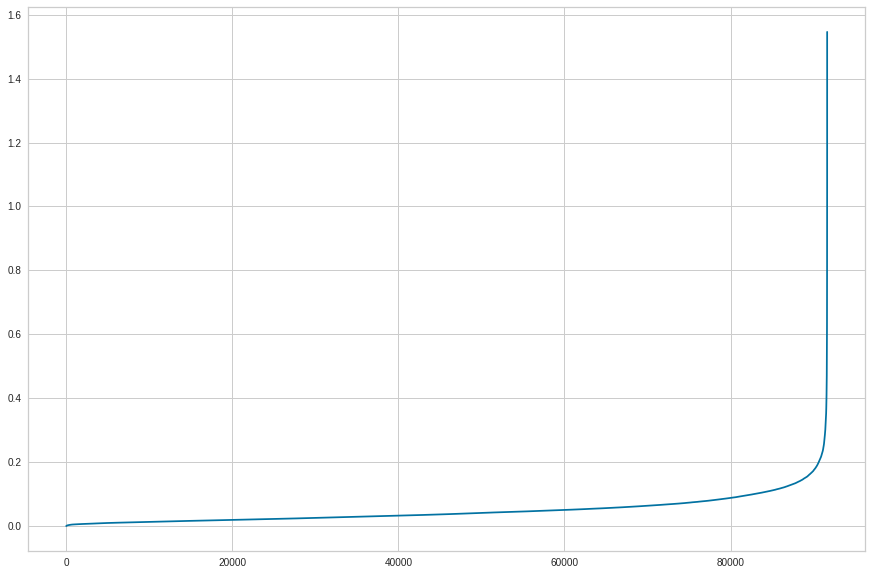

In [ ]:
fig, ax = plt.subplots(1, figsize = (15, 10))
plt.plot(distances)
plt.show()

Ici l'eps optimal serait 0.18

In [ ]:
clf_dbscan = DBSCAN(eps=0.18, min_samples=min_samples)
clf_dbscan.fit(df_sample)

DBSCAN(eps=0.18, min_samples=76)

In [ ]:
print(f"Silhouette score : {silhouette_score(df_sample, clf_dbscan.labels_)}")

Silhouette score : 0.2725896215453609


#<a name = "pred4"> Première selection </a> <a href ="#sommaire"> Retour au sommaire</a>

Au vu des différents résultats on va ici analyser les clusters obtenue pour le meilleur algorithme dans notre cas ici le kmeans avec comme parametre k = 3

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


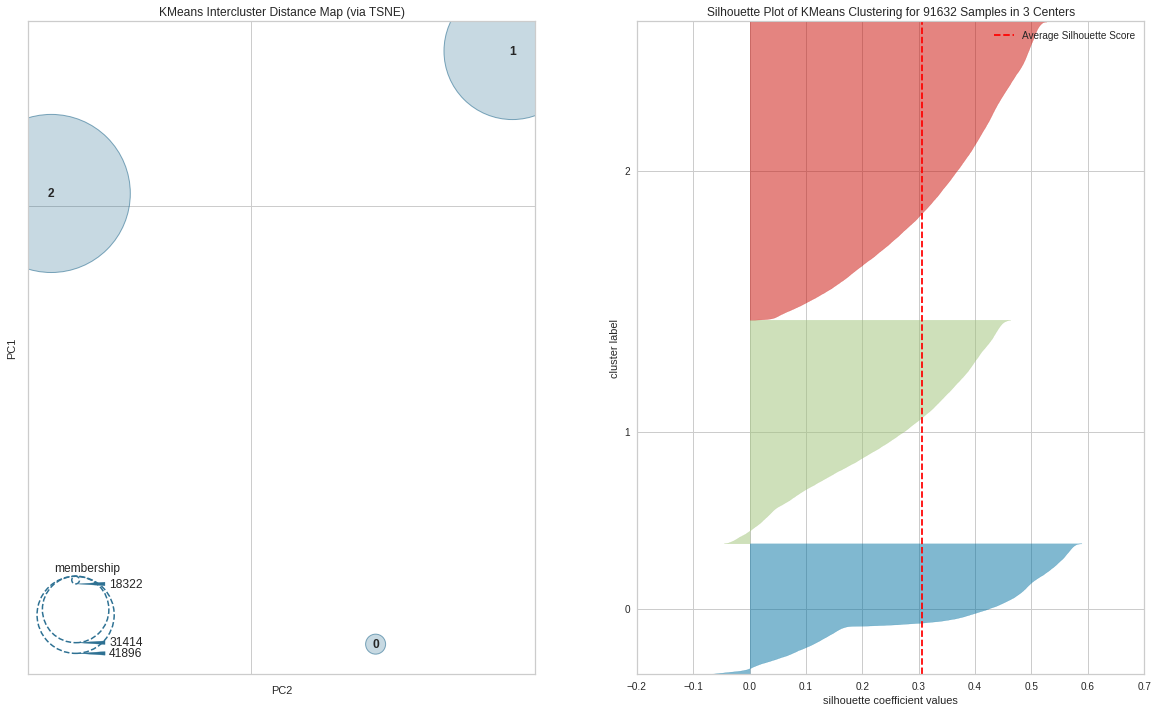

In [ ]:
import warnings
warnings.filterwarnings('ignore')
clf = KMeans(3, random_state=0)
visualizer(df_sc, clf)

Sur la projection en 2D sur les 2 premières composantes principales, on remarque que les différents clusters sont plutôt bien séparés, ce qui est confirmer sur la partie silhouette score mais on remarque qu'il y'a quelque erreur sur le 1er et 2éme cluster.

On va maintenant visualiser les différences entre clusters en prenant la moyenne pour voir si on peut en tirer quelques chose.

In [ ]:
clf.fit(df_sc)
kmeans_result = df_sc.copy()
kmeans_result['kmean_clusters'] = clf.labels_

kmean_mean = kmeans_result.groupby('kmean_clusters').mean().reset_index()
kmean_plot = kmean_mean.melt(id_vars=["kmean_clusters"], var_name = 'features', value_name = 'kmean_mean')

fig = px.line_polar(kmean_plot, r='kmean_mean', theta='features', line_close=True, color = 'kmean_clusters')
fig.show()

Malheureusement ici on se retrouve avec 3 clusters homogènes dont on pourra rien en tirer.

# <a name = "pred7">Segmentation classique (RFM) </a> <a href ="#sommaire"> Retour au sommaire</a>

Au vu des résultats obtenus, on va continuer sur cette partie avec la mise à l'échelle StandardScaler

Au vu des résultats précedents, on va essayer de faire une segmentation classique basée sur la méthode RFM afin d'essayer d'avoir une meilleure segmentation que les précedentes.

Pour cette partie aussi on va essayer deux versions de Kmeans:
- 1ere version avec les variables avec mise a l'échelle avec la méthode StandardScaler.
- 2ème version avec les variables avec transformation log sur les variables très asymètriques et mise à l'échelle avec la méthode StandardScaler.

In [ ]:
rfm = df[['total_spend', 'order_id', 'Recency']].copy()

for col in rfm.columns:
   skew = stats.skew(rfm[col])
   if skew < -0.5 or skew > 0.5:
     rfm[col] = np.log(rfm[col])

rfm_sc = StandardScaler().fit_transform(rfm)

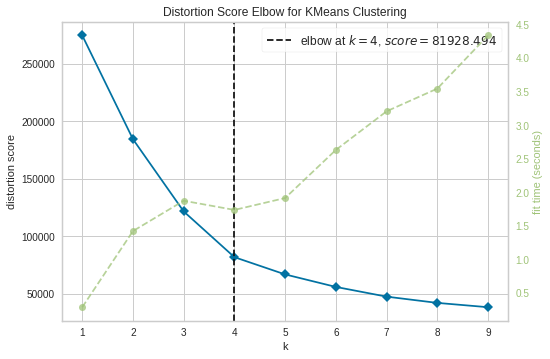

In [ ]:
clf = KMeans(random_state=0)
score_elbow(rfm_sc, clf)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



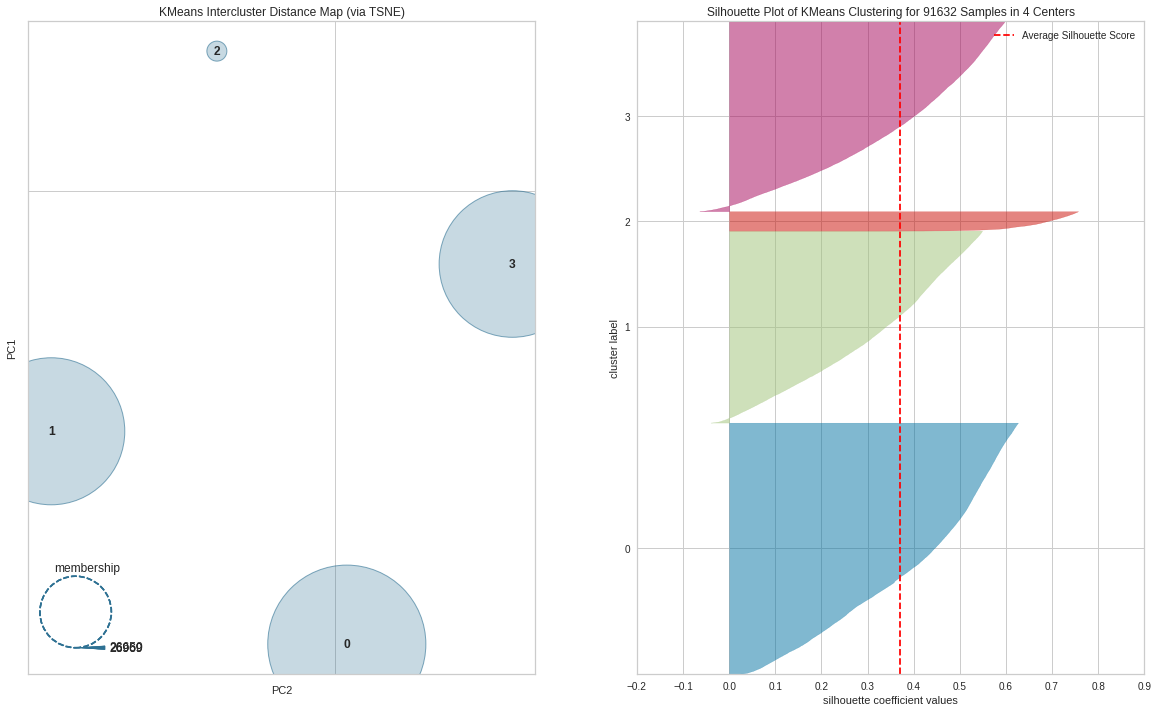

In [ ]:
clf = KMeans(4, random_state=0)
visualizer(rfm_sc, clf)

In [ ]:
clf = KMeans(4, random_state=0)
clf.fit(rfm_sc)
kmeans_result = rfm.copy()
kmeans_result['kmean_clusters'] = clf.labels_

kmean_mean = kmeans_result.groupby('kmean_clusters').mean().reset_index()
kmean_plot = kmean_mean.melt(id_vars=["kmean_clusters"], var_name = 'features', value_name = 'kmean_mean')

fig = px.line_polar(kmean_plot, r='kmean_mean', theta='features', line_close=True, color = 'kmean_clusters')
fig.show()

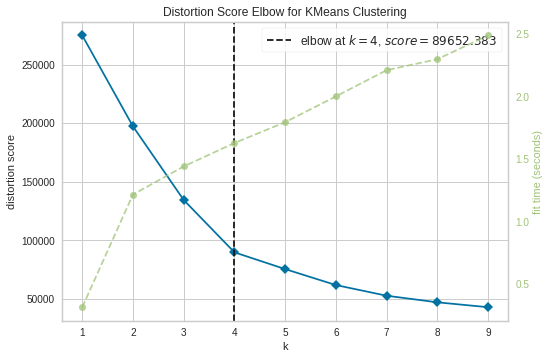

In [ ]:
rfm_classique  = df[['total_spend', 'order_id', 'Recency']].copy()
rfm_sc = StandardScaler().fit_transform(rfm_classique)
clf = KMeans(random_state=0)
score_elbow(rfm_sc, clf)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



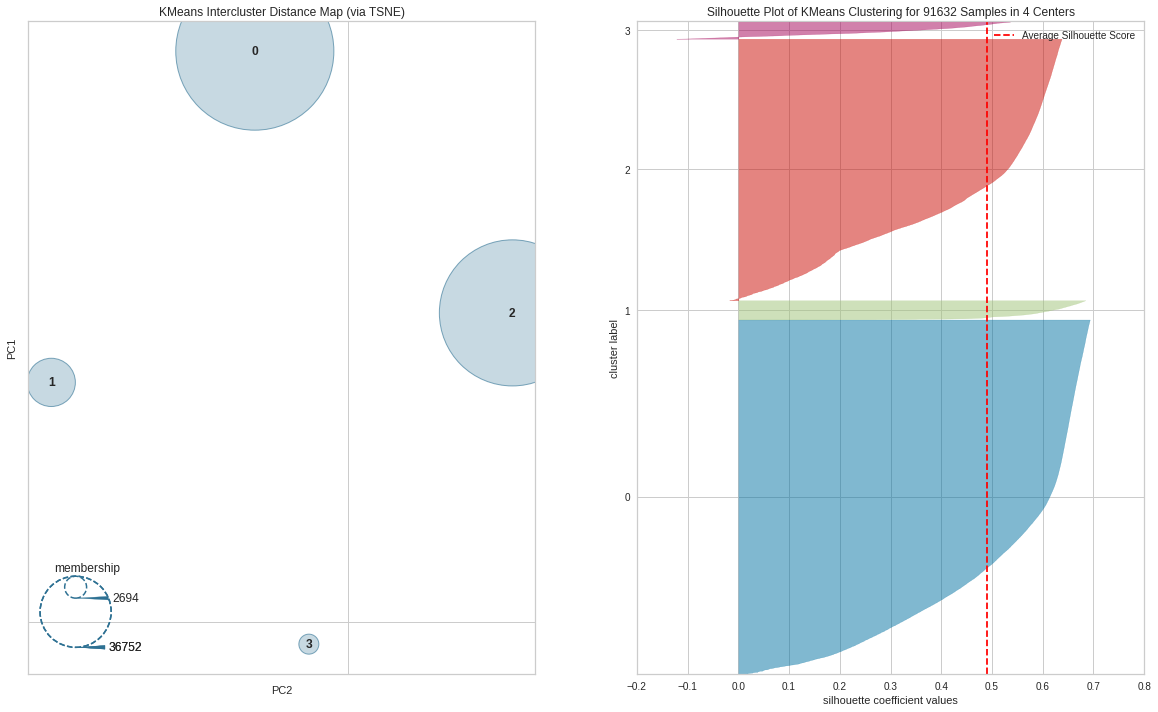

In [ ]:
clf = KMeans(4, random_state=0)
visualizer(rfm_sc, clf)

In [ ]:
clf = KMeans(4, random_state=0)
clf.fit(rfm_sc)
kmeans_result = rfm_classique.copy()
kmeans_result['kmean_clusters'] = clf.labels_

kmean_mean = kmeans_result.groupby('kmean_clusters').mean().reset_index()
kmean_plot = kmean_mean.melt(id_vars=["kmean_clusters"], var_name = 'features', value_name = 'kmean_mean')

fig = px.line_polar(kmean_plot, r='kmean_mean', theta='features', line_close=True, color = 'kmean_clusters')
fig.show()

In [ ]:
clusters = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']
clients = ['Clients prometteurs', 'Clients fidèles', "Clients perdus", "Clients qu'on doit pas perdre"]
carac = ["Acheteur récent, mais qui n’a pas dépensé beaucoup",
 "Dépense pas mal d'argent et assez souvent",
 "Clients avec la plus grande Récence, plus faible fréquence et montant total",
 "Clients avec les plus grosses dépense"]
nb_clients = kmeans_result.kmean_clusters.value_counts().values

In [ ]:
pd.DataFrame({'Clusters':clusters, 'Segment Client': clients, 'Caractéristiques':carac, 'Nombres clients':nb_clients})

,Clusters,Segment Client,Caractéristiques,Nombres clients
0,cluster 0,Clients prometteurs,"Acheteur récent, mais qui n’a pas dépensé beau...",49783
1,cluster 1,Clients fidèles,Dépense pas mal d'argent et assez souvent,36752
2,cluster 2,Clients perdus,"Clients avec la plus grande Récence, plus faib...",2694
3,cluster 3,Clients qu'on doit pas perdre,Clients avec les plus grosses dépense,2403


# <a name = "conc">Conclusion </a> <a href ="#sommaire"> Retour au sommaire</a>

On a vu qu'on avait du mal à segmenter les clients avec les différentes variables qu'on avait au départ. Mais on a réussi à avoir une bonne segmentation avec une silhouette score proche de 0.5 avec laquelle on pouvait tirer quelques conclusion sur les différents groupes. 
Il serait intérressant pour la suite d'ajouter d'autre informations concernant les clients comme par exemple l'âge, l'horaire... et voir si on obtient un meilleur clustering.